In [120]:
import time
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tiles3 as tc
from IPython.display import clear_output

In [127]:
class TileCoder:

    def __init__(self, iht_size):
        self.iht = tc.IHT(iht_size)

    def get_tiles(self, state):
        cos1, sin1, cos2, sin2, angular1, angular2 = state
        cos1 *= 6 / 2.0
        cos2 *= 6 / 2.0
        angular1 *= 7 / 25.1
        angular2 *= 7 / 56.5
        tiles = tc.tiles(self.iht, 12, [cos1, cos2, angular1, angular2], [0])
        tiles += tc.tiles(self.iht, 3, [cos1, cos2, angular1], [1])
        tiles += tc.tiles(self.iht, 3, [cos1, cos2, angular2], [2])
        tiles += tc.tiles(self.iht, 3, [cos1, angular1, angular2], [3])
        tiles += tc.tiles(self.iht, 3, [cos2, angular1, angular2], [4])
        tiles += tc.tiles(self.iht, 2, [cos1, cos2], [5])
        tiles += tc.tiles(self.iht, 2, [angular1, angular2], [6])
        tiles += tc.tiles(self.iht, 2, [cos1, angular1], [7])
        tiles += tc.tiles(self.iht, 2, [cos2, angular2], [8])
        tiles += tc.tiles(self.iht, 2, [cos1, angular2], [9])
        tiles += tc.tiles(self.iht, 2, [cos2, angular1], [10])
        tiles += tc.tiles(self.iht, 3, [cos1], [11])
        tiles += tc.tiles(self.iht, 3, [cos2], [12])
        tiles += tc.tiles(self.iht, 3, [angular1], [13])
        tiles += tc.tiles(self.iht, 3, [angular2], [14])
        return np.array(tiles)

class SarsaLambdaAgent:

    def __init__(self):
        self.iht_size = 16384
        self.epsilon = 0.0
        self.gamma = 1.0
        self.alpha = 0.2 / 48
        self.lambd = 0.9
        self.num_actions = 3
        self.w = np.zeros([self.num_actions, self.iht_size])
        self.z = np.zeros([self.num_actions, self.iht_size])
        self.tilecoder = TileCoder(self.iht_size)
        self.last_action = None
        self.last_tiles = None

    def select_action(self, tiles):
        action_values = self.w[:, tiles].sum(axis=1)
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = action_values.argmax()
        return action
    
    def start(self, state):
        tiles = self.tilecoder.get_tiles(state)
        action = self.select_action(tiles)
        self.z *= 0.0
        self.last_action = action
        self.last_tiles = tiles.copy()
        return self.last_action

    def step(self, state, reward):
        tiles = self.tilecoder.get_tiles(state)
        action = self.select_action(tiles)
        delta = reward
        for i in self.last_tiles:
            delta -= self.w[self.last_action][i]
            self.z[self.last_action][i] = 1
        for i in tiles:
            delta += self.gamma * self.w[action][i]
        self.w += self.alpha * delta * self.z
        self.z *= self.gamma * self.lambd
        self.last_action = action
        self.last_tiles = tiles.copy()
        return self.last_action

    def end(self, reward):
        delta = reward
        for i in self.last_tiles:
            delta -= self.w[self.last_action][i]
            self.z[self.last_action][i] = 1
        self.w += self.alpha * delta * self.z

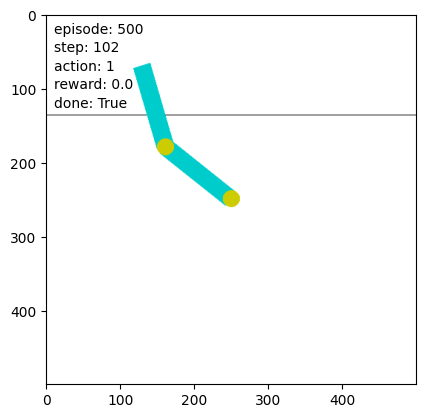

In [126]:
env = gym.make('Acrobot-v1', render_mode='rgb_array')
agent = SarsaLambdaAgent()
num_steps_list = []

num_episodes = 501
plot_episode = 1
render_episodes = [0, 10, 50, 100, 250, 500]
mode = 'render' # render or plot

for episode in range(num_episodes):
    state, _ = env.reset()
    action = agent.start(state)
    done, win = False, False
    num_steps = 0
    while not done:
        state, reward, done, over, _ = env.step(action)
        action = agent.step(state, reward)
        num_steps += 1
        if mode == 'render':
            if episode in render_episodes:
                img = env.render()
                plt.imshow(img)
                plt.text(10, 25, 'episode: ' + str(len(num_steps_list)))
                plt.text(10, 50, 'step: ' + str(num_steps))
                plt.text(10, 75, 'action: ' + str(action))
                plt.text(10, 100, 'reward: ' + str(reward))
                plt.text(10, 125, 'done: ' + str(done))
                plt.show()
                clear_output(wait=True)
        if done or over:
            agent.end(reward)
            if episode in render_episodes:
                time.sleep(1.0)
            break
        
    num_steps_list.append(num_steps)
    if mode == 'plot':
        if episode % plot_episode == 0:
            plt.figure(figsize=(4, 3))
            plt.plot(num_steps_list, color='royalblue')
            plt.grid(alpha=0.2)
            plt.title('SARSA(λ) for Acrobot-v1')
            plt.xlabel('episode')
            plt.ylabel('num_steps')
            plt.show()
            clear_output(wait=True)

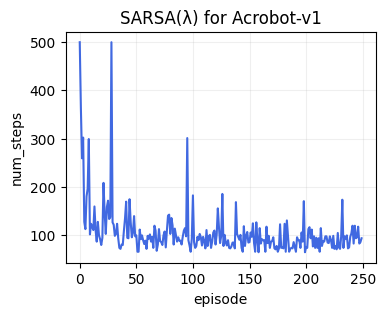

In [134]:
plt.figure(figsize=(4, 3))
plt.plot(num_steps_list[:250], color='royalblue')
plt.grid(alpha=0.2)
plt.title('SARSA(λ) for Acrobot-v1')
plt.xlabel('episode')
plt.ylabel('num_steps')
plt.show()
clear_output(wait=True)